In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# -------------------------------------------------------------------
# parameters
# -------------------------------------------------------------------
# constants
L        = 1.0       # 1-D computational domain size
N_In     = 2000      # number of computing cells
cfl      = 1.0       # Courant factor
nghost   = 1      # number of ghost zones
gamma    = 5.0/3.0   # ratio of specific heats
end_time = 0.4       # simulation time

# derived constants
N  = N_In + 2*nghost  # total number of cells including ghost zones
dx = L/N_In           # spatial resolution

# Initialize variables for simulation
t = 0.0
U = np.empty((N, 3))
x = np.linspace(-nghost*dx, L + nghost*dx, N)  # Including ghost cells



In [3]:
def read_shock_data(filepath):
    # Initialize lists to store data
    rho, vx, pres = [], [], []

    with open(filepath, 'r') as file:
        for line in file:
            # Skip comments
            if line.startswith('#'):
                continue

            # Split the line into components and convert to float
            parts = line.split()
            if len(parts) >= 6:  # Make sure the line has enough columns
                rho.append(float(parts[1]))
                vx.append(float(parts[2]))
                pres.append(float(parts[5]))

    # Convert lists to numpy arrays
    rho = np.array(rho)
    vx = np.array(vx)
    pres = np.array(pres)

    return rho, vx, pres

def calculate_min_squared_difference(array1, target_array):

    return np.std((array1 - target_array))

In [4]:
def InitialCondition( x ):
    #  Sod shock tube
   if ( x < 0.5*L ):
      d = 1.25e3  # density
      u = 0.0  # velocity x
      P = 5e2  # pressure
      E = P/(gamma-1.0) + 0.5*d*u**2.0    # energy density
   else:
      d = 1.25e2
      u = 0.0
      P = 5
      E = P/(gamma-1.0) + 0.5*d*u**2.0

#  conserved variables [0/1/2] <--> [density/momentum x/energy]
   return np.array( [d, d*u, E] )

def BoundaryCondition( U ):
    #  outflow
   U[0:nghost]   = U[nghost]
   U[N-nghost:N] = U[N-nghost-1]

def ComputePressure( d, px, e ):
    P = (gamma-1.0)*( e - 0.5*px**2.0/d )
    return P

def ComputeTimestep( U ):
    P = ComputePressure( U[:,0], U[:,1], U[:,2] )
    a = ( gamma*P/U[:,0] )**0.5
    u = np.abs( U[:,1]/U[:,0] )

    max_info_speed = np.amax( u + a )
    dt_cfl         = cfl*dx/max_info_speed
    dt_end         = end_time - t

    return min( dt_cfl, dt_end )

def Conserved2Flux( U ):
    flux = np.empty( 3 )

    P = ComputePressure( U[0], U[1], U[2] )
    u = U[1] / U[0]

    flux[0] = U[1]
    flux[1] = u*U[1] + P
    flux[2] = u*( U[2] + P )

    return flux



In [5]:


# Define the functions (same as before) here:
# InitialCondition, BoundaryCondition, ComputePressure, ComputeTimestep, Conserved2Flux

# -------------------------------------------------------------------
# Set initial condition
# -------------------------------------------------------------------
def evolution(label):   
    global t 
    for j in range(N_In):
        U[j+nghost] = InitialCondition(x[j+nghost])

    # -------------------------------------------------------------------
    # Main evolution loop
    # -------------------------------------------------------------------
    while t < end_time:
        # Set the boundary conditions
        BoundaryCondition(U)

        # Estimate time-step from the CFL condition
        dt = ComputeTimestep(U)
        # print(f"t = {t:13.7e}, dt = {dt:13.7e}")

        # Compute fluxes and update U
        flux = np.empty((N, 3))
        for j in range(nghost, N-nghost+1):
            if label == 0:
            # Lax-Wendroff scheme
                U_half = 0.5*(U[j] + U[j-1]) - 0.5*dt/dx*(Conserved2Flux(U[j]) - Conserved2Flux(U[j-1]))
                flux[j] = Conserved2Flux(U_half)
            elif label == 1: 
            # Lax-Friedrichs scheme
                flux[j] = 0.5*(  Conserved2Flux( U[j] ) + Conserved2Flux( U[j-1] ) \
                                -dx/dt*( U[j] - U[j-1] )  )

        U[nghost:N-nghost] -= dt/dx*(flux[nghost+1:N-nghost+1] - flux[nghost:N-nghost])

        # Update time
        t += dt

    # -------------------------------------------------------------------
    # After the loop, extract and print final results for verification or further analysis
    # -------------------------------------------------------------------
    d_final = U[nghost:N-nghost, 0]
    u_final = U[nghost:N-nghost, 1] / d_final
    P_final = ComputePressure(d_final, U[nghost:N-nghost, 1], U[nghost:N-nghost, 2])

    rho, vx, pres = read_shock_data('strong_shock.txt')
    print("Final density:", calculate_min_squared_difference(d_final, rho))
    print("Final velocity:", calculate_min_squared_difference(u_final, vx))
    print("Final pressure:", calculate_min_squared_difference(P_final, pres))
    return d_final, u_final, P_final



Final density: 2.6993451558884556
Final velocity: 0.003237340552001587
Final pressure: 0.75440538718905
Final density: 11.305242453407383
Final velocity: 0.025150234451049074
Final pressure: 3.9367651297904325


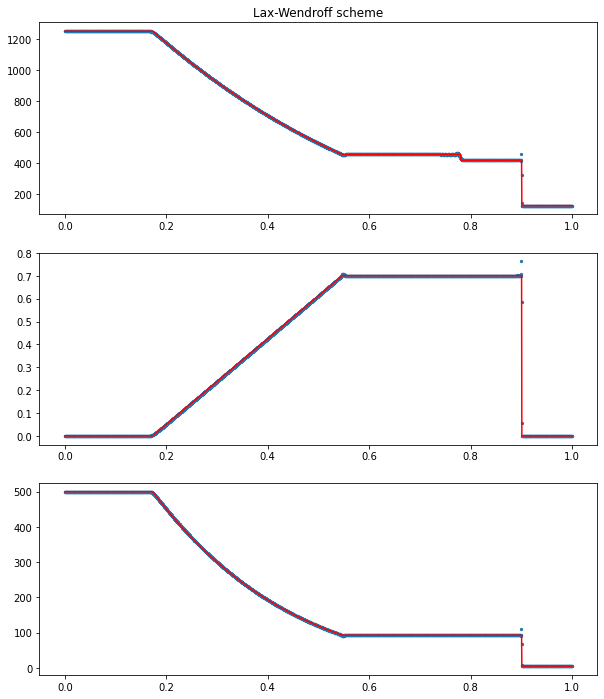

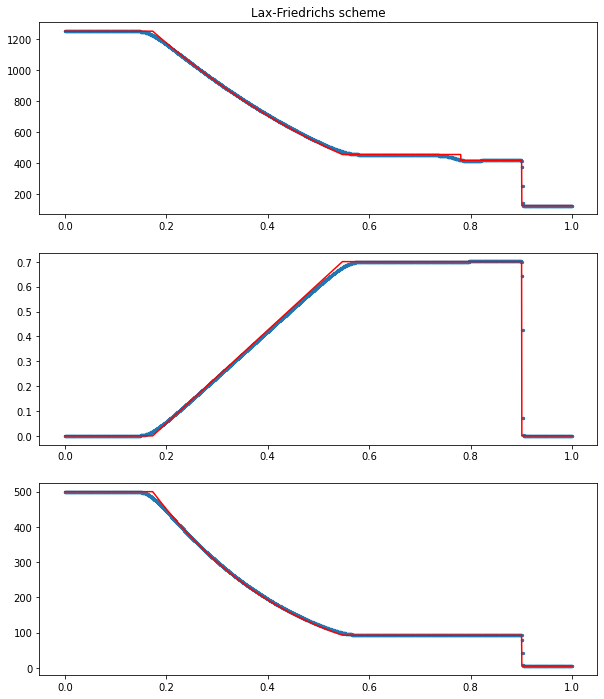

In [6]:
# rho, vx, pres = read_shock_data('strong_shock.txt')
for i in range(2):
    d_final, u_final, P_final = evolution(i)
    r = np.linspace(0,1,2000)
    rho, vx, pres = read_shock_data('strong_shock.txt')
    t = 0
    if i == 0:
        plt.figure(figsize=(10, 12))
        plt.subplot(3,1,1)
        plt.title('Lax-Wendroff scheme')
        plt.scatter(r,d_final,s=5,label = 'simulate density')
        plt.plot(r,rho,color='red', label = 'analytical solution')
        plt.subplot(3,1,2)
        plt.scatter(r,u_final,s=5,label = 'simulate velocity')
        plt.plot(r,vx,color='red', label = 'analytical solution')
        plt.subplot(3,1,3)
        plt.scatter(r,P_final,s=5,label = 'simulate pressure')
        plt.plot(r,pres,color='red', label = 'analytical solution')
    if i == 1:
        plt.figure(figsize=(10, 12))
        plt.subplot(3,1,1)
        plt.title('Lax-Friedrichs scheme')
        plt.scatter(r,d_final,s=5,label = 'simulate density')
        plt.plot(r,rho,color='red', label = 'analytical solution')
        plt.subplot(3,1,2)
        plt.scatter(r,u_final,s=5,label = 'simulate velocity')
        plt.plot(r,vx,color='red', label = 'analytical solution')
        plt.subplot(3,1,3)
        plt.scatter(r,P_final,s=5,label = 'simulate pressure')
        plt.plot(r,pres,color='red', label = 'analytical solution')       


In [12]:
# constants
L        = 1.0       # 1-D computational domain size
N_In     = 2000       # number of computing cells
cfl      = 1.0       # Courant factor
nghost   = 2        # number of ghost zones
gamma    = 5.0/3.0   # ratio of specific heats
end_time = 0.4       # simulation time

# derived constants
N  = N_In + 2*nghost    # total number of cells including ghost zones
dx = L/N_In             # spatial resolution

# plotting parameters
nstep_per_image = 1     # plotting frequency

t = 0.0
x = np.empty( N_In )
U = np.empty( (N,5) )

In [13]:
def InitialCondition( x ):
    #  Sod shock tube
   if ( x < 0.5*L ):
      d = 1250  # density
      u = 0.0  # velocity x
      v = 0.0  # velocity y
      w = 0.0  # velocity z
      P = 500  # pressure
      E = P/(gamma-1.0) + 0.5*d*( u**2.0 + v**2.0 + w**2.0 )   # energy density
   else:
      d = 125
      u = 0.0
      v = 0.0
      w = 0.0
      P = 5
      E = P/(gamma-1.0) + 0.5*d*( u**2.0 + v**2.0 + w**2.0 )

#  conserved variables [0/1/2/3/4] <--> [density/momentum x/momentum y/momentum z/energy]
   return np.array( [d, d*u, d*v, d*w, E] )


In [18]:
# -------------------------------------------------------------------
# define initial condition
# -------------------------------------------------------------------
def InitialCondition( x ):
#  Sod shock tube
   if ( x < 0.5*L ):
      d = 1250  # density
      u = 0.0  # velocity x
      v = 0.0  # velocity y
      w = 0.0  # velocity z
      P = 500  # pressure
      E = P/(gamma-1.0) + 0.5*d*( u**2.0 + v**2.0 + w**2.0 )   # energy density
   else:
      d = 125
      u = 0.0
      v = 0.0
      w = 0.0
      P = 5
      E = P/(gamma-1.0) + 0.5*d*( u**2.0 + v**2.0 + w**2.0 )

#  conserved variables [0/1/2/3/4] <--> [density/momentum x/momentum y/momentum z/energy]
   return np.array( [d, d*u, d*v, d*w, E] )


# -------------------------------------------------------------------
# define boundary condition by setting ghost zones
# -------------------------------------------------------------------
def BoundaryCondition( U ):
#  outflow
   U[0:nghost]   = U[nghost]
   U[N-nghost:N] = U[N-nghost-1]


# -------------------------------------------------------------------
# compute pressure
# -------------------------------------------------------------------
def ComputePressure( d, px, py, pz, e ):
   P = (gamma-1.0)*( e - 0.5*(px**2.0 + py**2.0 + pz**2.0)/d )
   assert np.all( P > 0 ), "negative pressure !!"
   return P


# -------------------------------------------------------------------
# compute time-step by the CFL condition
# -------------------------------------------------------------------
def ComputeTimestep( U ):
   P = ComputePressure( U[:,0], U[:,1], U[:,2], U[:,3], U[:,4] )
   a = ( gamma*P/U[:,0] )**0.5
   u = np.abs( U[:,1]/U[:,0] )
   v = np.abs( U[:,2]/U[:,0] )
   w = np.abs( U[:,3]/U[:,0] )

#  maximum information speed in 3D
   max_info_speed = np.amax( u + a )
   dt_cfl         = cfl*dx/max_info_speed
   dt_end         = end_time - t

   return min( dt_cfl, dt_end )


# -------------------------------------------------------------------
# compute limited slope
# -------------------------------------------------------------------
def ComputeLimitedSlope( L, C, R):
#  compute the left and right slopes
   slope_L = C - L
   slope_R = R - C

#  apply the van-Leer limiter
   slope_LR      = slope_L*slope_R
   slope_limited = np.where( slope_LR>0.0, 2.0*slope_LR/(slope_L+slope_R), 0.0 )

   return slope_limited


# -------------------------------------------------------------------
# convert conserved variables to primitive variables
# -------------------------------------------------------------------
def Conserved2Primitive( U ):
   W = np.empty( 5 )

   W[0] = U[0]
   W[1] = U[1]/U[0]
   W[2] = U[2]/U[0]
   W[3] = U[3]/U[0]
   W[4] = ComputePressure( U[0], U[1], U[2], U[3], U[4] )

   return W


# -------------------------------------------------------------------
# convert primitive variables to conserved variables
# -------------------------------------------------------------------
def Primitive2Conserved( W ):
   U = np.empty( 5 )

   U[0] = W[0]
   U[1] = W[0]*W[1]
   U[2] = W[0]*W[2]
   U[3] = W[0]*W[3]
   U[4] = W[4]/(gamma-1.0) + 0.5*W[0]*( W[1]**2.0 + W[2]**2.0 + W[3]**2.0 )

   return U


# -------------------------------------------------------------------
# piecewise-linear data reconstruction
# -------------------------------------------------------------------
def DataReconstruction_PLM( U ):

#  allocate memory
   W = np.empty( (N,5) )
   L = np.empty( (N,5) )
   R = np.empty( (N,5) )

#  conserved variables --> primitive variables
   for j in range( N ):
      W[j] = Conserved2Primitive( U[j] )

   for j in range( 1, N-1 ):
#     compute the left and right states of each cell
      slope_limited = ComputeLimitedSlope( W[j-1], W[j], W[j+1] )

#     get the face-centered variables
      L[j] = W[j] - 0.5*slope_limited
      R[j] = W[j] + 0.5*slope_limited

#     ensure face-centered variables lie between nearby volume-averaged (~cell-centered) values
      L[j] = np.maximum( L[j], np.minimum( W[j-1], W[j] ) )
      L[j] = np.minimum( L[j], np.maximum( W[j-1], W[j] ) )
      R[j] = 2.0*W[j] - L[j]

      R[j] = np.maximum( R[j], np.minimum( W[j+1], W[j] ) )
      R[j] = np.minimum( R[j], np.maximum( W[j+1], W[j] ) )
      L[j] = 2.0*W[j] - R[j]

#     primitive variables --> conserved variables
      L[j] = Primitive2Conserved( L[j] )
      R[j] = Primitive2Conserved( R[j] )

   return L, R


# -------------------------------------------------------------------
# convert conserved variables to fluxes
# -------------------------------------------------------------------
def Conserved2Flux( U ):
   flux = np.empty( 5 )

   P = ComputePressure( U[0], U[1], U[2], U[3], U[4] )
   u = U[1] / U[0]

   flux[0] = U[1]
   flux[1] = u*U[1] + P
   flux[2] = u*U[2]
   flux[3] = u*U[3]
   flux[4] = u*( U[4] + P )

   return flux


# -------------------------------------------------------------------
# Roe's Riemann solver
# -------------------------------------------------------------------
def Roe( L, R ):
#  compute the enthalpy of the left and right states: H = (E+P)/rho
   P_L = ComputePressure( L[0], L[1], L[2], L[3], L[4] )
   P_R = ComputePressure( R[0], R[1], R[2], R[3], R[4] )
   H_L = ( L[4] + P_L )/L[0]
   H_R = ( R[4] + P_R )/R[0]

#  compute Roe average values
   rhoL_sqrt = L[0]**0.5
   rhoR_sqrt = R[0]**0.5

   u  = ( L[1]/rhoL_sqrt + R[1]/rhoR_sqrt ) / ( rhoL_sqrt + rhoR_sqrt )
   v  = ( L[2]/rhoL_sqrt + R[2]/rhoR_sqrt ) / ( rhoL_sqrt + rhoR_sqrt )
   w  = ( L[3]/rhoL_sqrt + R[3]/rhoR_sqrt ) / ( rhoL_sqrt + rhoR_sqrt )
   H  = ( rhoL_sqrt*H_L  + rhoR_sqrt*H_R  ) / ( rhoL_sqrt + rhoR_sqrt )
   V2 = u*u + v*v + w*w
#  check negative pressure
   assert H-0.5*V2 > 0.0, "negative pressure!"
   a  = ( (gamma-1.0)*(H - 0.5*V2) )**0.5

#  compute the amplitudes of different characteristic waves
   dU     = R - L
   amp    = np.empty( 5 )
   amp[2] = dU[2] - v*dU[0]
   amp[3] = dU[3] - w*dU[0]
   amp[1] = (gamma-1.0)/a**2.0 \
            *( dU[0]*(H-u**2.0) + u*dU[1] - dU[4] + v*amp[2] + w*amp[3] )
   amp[0] = 0.5/a*( dU[0]*(u+a) - dU[1] - a*amp[1] )
   amp[4] = dU[0] - amp[0] - amp[1]

#  compute the eigenvalues and right eigenvector matrix
   EigenValue    = np.array( [u-a, u, u, u, u+a] )
   EigenVector_R = np.array(  [ [1.0, u-a,   v,   w,  H-u*a],
                                [1.0,   u,   v,   w, 0.5*V2],
                                [0.0, 0.0, 1.0, 0.0,      v],
                                [0.0, 0.0, 0.0, 1.0,      w],
                                [1.0, u+a,   v,   w,  H+u*a] ]  )

#  compute the fluxes of the left and right states
   flux_L = Conserved2Flux( L )
   flux_R = Conserved2Flux( R )

#  compute the Roe flux
   amp *= np.abs( EigenValue )
   flux = 0.5*( flux_L + flux_R ) - 0.5*amp.dot( EigenVector_R )

   return flux



In [19]:
def evolution(label ):   
    global t 
    for j in range( N_In ):
       x[j] = (j+0.5)*dx   # cell-centered coordinates
       U[j+nghost] = InitialCondition( x[j] )

    # -------------------------------------------------------------------
    # Main evolution loop
    # -------------------------------------------------------------------
    while t < end_time:
        # Set the boundary conditions
        BoundaryCondition( U )

#        estimate time-step from the CFL condition
        dt = ComputeTimestep( U )
        # print( "t = %13.7e --> %13.7e, dt = %13.7e" % (t,t+dt,dt) )

#        data reconstruction
        L, R = DataReconstruction_PLM( U )

#        update the face-centered variables by 0.5*dt
        for j in range( 1, N-1 ):
            flux_L = Conserved2Flux( L[j] )
            flux_R = Conserved2Flux( R[j] )
            dflux  = 0.5*dt/dx*( flux_R - flux_L )
            L[j]  -= dflux
            R[j]  -= dflux

#        compute fluxes
        flux = np.empty( (N,5) )
        for j in range( nghost, N-nghost+1 ):
#           R[j-1] is the LEFT state at the j+1/2 inteface
            flux[j] = Roe( R[j-1], L[j]  )

#        update the volume-averaged input variables by dt
        U[nghost:N-nghost] -= dt/dx*( flux[nghost+1:N-nghost+1] - flux[nghost:N-nghost] )

#        update time
        t = t + dt

    # -------------------------------------------------------------------
    # After the loop, extract and print final results for verification or further analysis
    # -------------------------------------------------------------------
    d_final = U[nghost:N-nghost, 0]
    u_final = U[nghost:N-nghost, 1] /  U[nghost:N-nghost,0]
    P_final = ComputePressure( U[nghost:N-nghost,0], U[nghost:N-nghost,1], U[nghost:N-nghost,2],
                        U[nghost:N-nghost,3], U[nghost:N-nghost,4] )

    rho, vx, pres = read_shock_data('strong_shock.txt')
    print("Final density:", calculate_min_squared_difference(d_final, rho))
    print("Final velocity:", calculate_min_squared_difference(u_final, vx))
    print("Final pressure:", calculate_min_squared_difference(P_final, pres))

    return d_final, u_final, P_final


C:\Users\user\AppData\Local\Temp\ipykernel_26924\162643376.py:71: RuntimeWarning: invalid value encountered in divide
  slope_limited = np.where( slope_LR>0.0, 2.0*slope_LR/(slope_L+slope_R), 0.0 )
C:\Users\user\AppData\Local\Temp\ipykernel_26924\162643376.py:71: RuntimeWarning: divide by zero encountered in divide
  slope_limited = np.where( slope_LR>0.0, 2.0*slope_LR/(slope_L+slope_R), 0.0 )


Final density: 2.458427625989424
Final velocity: 0.007013919496481882
Final pressure: 0.5700716270819476


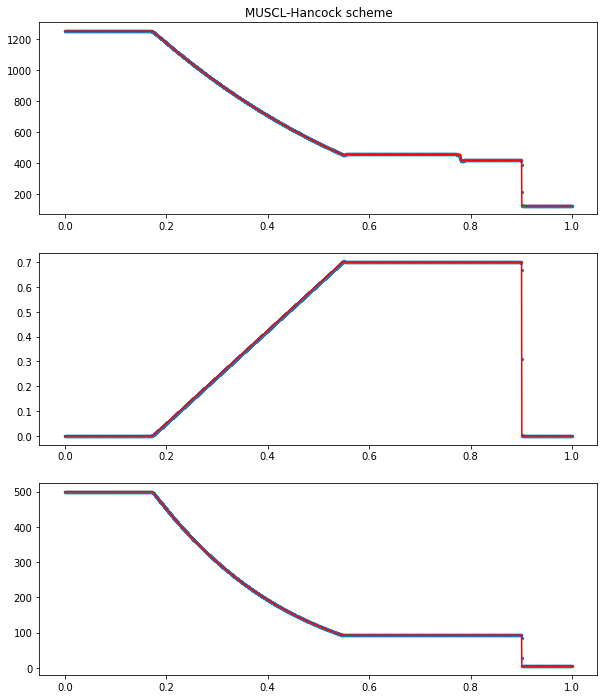

In [20]:
d_final, u_final, P_final = evolution(i)
r = np.linspace(0,1,2000)
rho, vx, pres = read_shock_data('strong_shock.txt')
t = 0

plt.figure(figsize=(10, 12))
plt.subplot(3,1,1)
plt.title('MUSCL-Hancock scheme')
plt.scatter(r,d_final,s=5,label = 'simulate density')
plt.plot(r,rho,color='red', label = 'analytical solution')
plt.subplot(3,1,2)
plt.scatter(r,u_final,s=5,label = 'simulate velocity')
plt.plot(r,vx,color='red', label = 'analytical solution')
plt.subplot(3,1,3)
plt.scatter(r,P_final,s=5,label = 'simulate pressure')
plt.plot(r,pres,color='red', label = 'analytical solution')